# **Mount Drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Import Necessary Libraries**

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import (StandardScaler, OrdinalEncoder,LabelEncoder, MinMaxScaler, OneHotEncoder)
!pip install -q keras
from keras.utils import to_categorical
from sklearn.preprocessing import Normalizer, MaxAbsScaler , RobustScaler, PowerTransformer
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, SimpleRNN , GRU , Activation
# from keras.layers.normalization import BatchNormalization
from keras import optimizers
import tensorflow as tf
from tensorflow.keras import layers
from keras.layers import Convolution1D, Dense, Dropout, Flatten, MaxPooling1D , AveragePooling1D
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, Flatten, Dropout, Reshape, LayerNormalization, MultiHeadAttention,Concatenate
import keras
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Conv1D, GlobalMaxPooling1D, Activation, Dense, Dropout, Lambda
from keras.utils import to_categorical

from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import load_model
!pip install -q pycm
import pycm
from pycm import *
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.metrics import (precision_score, recall_score,
                             f1_score, accuracy_score,mean_squared_error,mean_absolute_error)

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

# **Import Dataset From Drive**

In [3]:
train='/content/drive/My Drive/Datasets/NSL-KDD/nsl-kdd/KDDTrain+.txt'
test='/content/drive/My Drive/Datasets/NSL-KDD/nsl-kdd/KDDTest+.txt'
test21='/content/drive/My Drive/Datasets/NSL-KDD/nsl-kdd/KDDTest-21.txt'

# **Preparing Dataset**

In [4]:
featureV=["duration","protocol_type","service","flag","src_bytes","dst_bytes","land","wrong_fragment","urgent","hot",
          "num_failed_logins","logged_in","num_compromised","root_shell","su_attempted","num_root","num_file_creations","num_shells",
          "num_access_files","num_outbound_cmds","is_host_login","is_guest_login","count","srv_count","serror_rate","srv_serror_rate",
          "rerror_rate","srv_rerror_rate","same_srv_rate","diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count", 
          "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate","dst_host_srv_diff_host_rate","dst_host_serror_rate",
          "dst_host_srv_serror_rate","dst_host_rerror_rate","dst_host_srv_rerror_rate","label","difficulty"]

binary_attack=['normal','ipsweep', 'nmap', 'portsweep','satan', 'saint', 'mscan','back', 'land', 'neptune', 'pod', 'smurf',
               'teardrop', 'apache2', 'udpstorm', 'processtable','mailbomb','buffer_overflow', 'loadmodule', 'perl', 'rootkit',
               'xterm', 'ps', 'sqlattack','ftp_write', 'guess_passwd', 'imap', 'multihop','phf', 'spy', 'warezclient',
               'warezmaster','snmpgetattack','named', 'xlock', 'xsnoop','sendmail', 'httptunnel', 'worm', 'snmpguess']

multiclass_attack={ 'normal': 'normal',
        'probe': ['ipsweep.', 'nmap.', 'portsweep.','satan.', 'saint.', 'mscan.'],
        'dos': ['back.', 'land.', 'neptune.', 'pod.', 'smurf.','teardrop.', 'apache2.', 'udpstorm.', 'processtable.','mailbomb.'],
        'u2r': ['buffer_overflow.', 'loadmodule.', 'perl.', 'rootkit.','xterm.', 'ps.', 'sqlattack.'],
        'r2l': ['ftp_write.', 'guess_passwd.', 'imap.', 'multihop.','phf.', 'spy.', 'warezclient.', 'warezmaster.','snmpgetattack.',
                   'named.', 'xlock.', 'xsnoop.','sendmail.', 'httptunnel.', 'worm.', 'snmpguess.']}

In [5]:
train_data=pd.read_csv(train,names=featureV)
test_data=pd.read_csv(test,names=featureV)
test_21 = pd.read_csv(test21, names= featureV)

# **Heatmap**

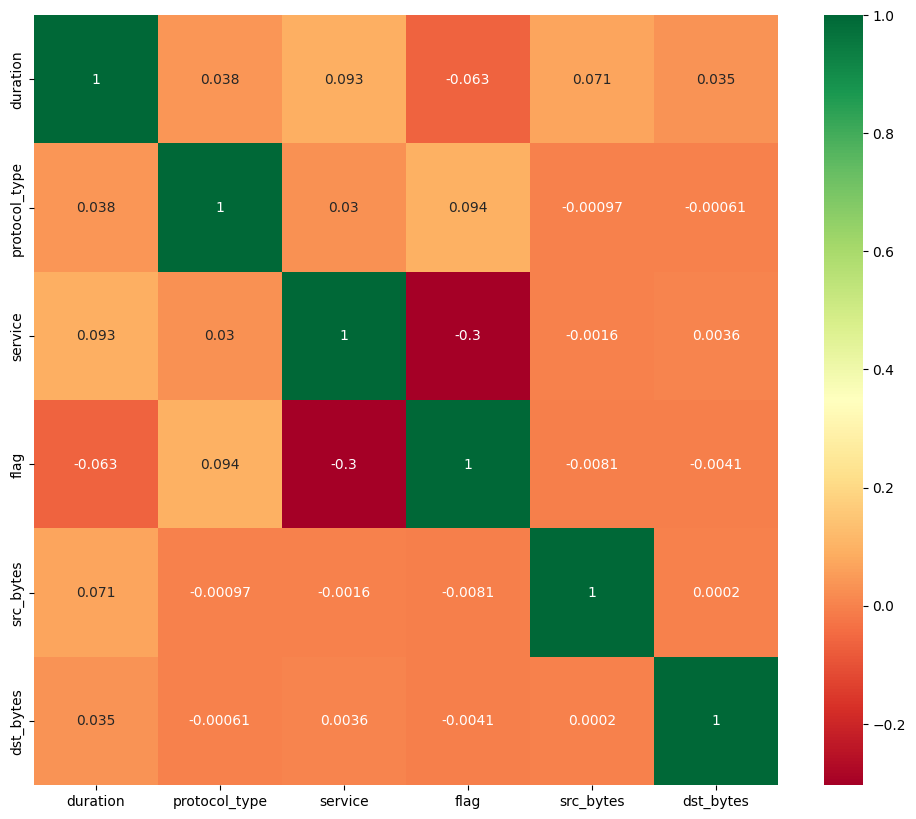

In [6]:
heatmap = pd.read_csv(train,names=featureV)
cat_cols = ["protocol_type", "service", "flag"]
le = LabelEncoder()
for col in cat_cols:
    heatmap[col] = le.fit_transform(heatmap[col])

train_data_heatmap = heatmap[['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes']]

plt.figure(figsize=(12,10))
p=sns.heatmap(train_data_heatmap.corr(), annot=True,cmap ='RdYlGn')
plt.savefig('heatmap.png')

# **Data Preprocessing**

In [7]:
train_data = train_data.drop_duplicates()
train_data = train_data.dropna()

test_data = test_data.drop_duplicates()
test_data = test_data.dropna()

test_21 = test_21.drop_duplicates()
test_21 = test_21.dropna()

# **Hybrid Feature Selection**

In [8]:
train_data = train_data[['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'label']]

# One-hot encode the categorical data
train_data = pd.get_dummies(train_data, columns=['protocol_type', 'service', 'flag'])

test_data = test_data[['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'label']]

# One-hot encode the categorical data
test_data = pd.get_dummies(test_data, columns=['protocol_type', 'service', 'flag'])

test_21 = test_21[['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'label']]

# One-hot encode the categorical data
test_21 = pd.get_dummies(test_21, columns=['protocol_type', 'service', 'flag'])

In [9]:
test_data['dummy1'] = 0
test_data['dummy2'] = 0
test_data['dummy3'] = 0
test_data['dummy4'] = 0
test_data['dummy5'] = 0
test_data['dummy6'] = 0

# <<-------------------------------------------------------------------------------->>

test_21['dummy1'] = 0
test_21['dummy2'] = 0
test_21['dummy3'] = 0
test_21['dummy4'] = 0
test_21['dummy5'] = 0
test_21['dummy6'] = 0
test_21['dummy7'] = 0
test_21['dummy8'] = 0

In [10]:
print(np.shape(train_data))
print(np.shape(test_data))
print(np.shape(test_21))

(125973, 88)
(22544, 88)
(11850, 88)


In [11]:
def preprocessing(data,cls,df):
  
#----------attack categorization----------------->
  data['label']=data['label'].replace(['normal.','normal'],0)

#----------------------binary classification--------------------->
  if cls=='binary':
    for i in range(len(binary_attack)):
      data['label'] = data['label'].replace(binary_attack[i], 1)
  
#---------------multiclass classification-------------------->  
  elif cls=='multiclass':
    for i in range(len(multiclass_attack['probe'])):
      data['label']=data['label'].replace([multiclass_attack['probe'][i],multiclass_attack['probe'][i][:-1]],1)
    
    for i in range(len(multiclass_attack['dos'])):
      data['label']=data['label'].replace([multiclass_attack['dos'][i],multiclass_attack['dos'][i][:-1]],2)
    
    for i in range(len(multiclass_attack['u2r'])):
      data['label']=data['label'].replace([multiclass_attack['u2r'][i],multiclass_attack['u2r'][i][:-1]],3)
    
    for i in range(len(multiclass_attack['r2l'])):
      data['label'] = data['label'].replace([multiclass_attack['r2l'][i],multiclass_attack['r2l'][i][:-1]],4)
#------------------------------------------------>


#-------------------------splitting features and labels---------------->
  y=data['label']
  x=data.iloc[:, :-1]

#-----------------converting to binary label vectors--------------------------------------> 
  yt=y.copy()
  yt=pd.get_dummies(yt)
#------------------------------------------------------------------------------>

  x = MinMaxScaler(feature_range=(0, 1)).fit_transform(x)
    
  return x,yt

In [12]:
x_train,Y_train=preprocessing(train_data,cls='multiclass',df='train')
x_test,Y_test=preprocessing(test_data,cls='multiclass',df='test')
x_21_test, y_21_test = preprocessing(test_21, cls = 'multiclass', df = 'test21')

In [13]:
print(np.shape(x_train))
print(np.shape(Y_train))
print(np.shape(x_test))
print(np.shape(Y_test))
print(np.shape(x_21_test))
print(np.shape(y_21_test))

(125973, 87)
(125973, 5)
(22544, 87)
(22544, 5)
(11850, 87)
(11850, 5)


In [14]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(125973, 87, 1)

In [15]:
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
x_test.shape

(22544, 87, 1)

In [16]:
x_21_test = np.reshape(x_21_test, (x_21_test.shape[0], x_21_test.shape[1], 1))
x_21_test.shape

(11850, 87, 1)

# **Model**

In [17]:
inputs = Input(shape=(x_train.shape[1], 1))
x = Convolution1D(512, 3, padding="same",activation="relu")(inputs)
x = tf.keras.layers.LayerNormalization()(x)
# model.add(Convolution1D(32, 3, activation="relu"))
x = MaxPooling1D(pool_size=(2))(x)
# model.add(tf.keras.layers.LayerNormalization())
# model.add(GRU(units = 128, return_sequences=True, input_shape = (x_train.shape[1], 1)))
x = Dropout(0.5)(x) 
x = Convolution1D(128, 3, padding="same",activation="relu")(x)
x = MaxPooling1D(pool_size=(2))(x)
x = Dropout(0.5)(x) 

x = Convolution1D(64, 4, padding="same",activation="relu")(x)
x = MaxPooling1D(pool_size=(2))(x)
x = Dropout(0.5)(x)
print(x.shape)

num_heads = 16
key_dim = 128
value_dim = 128
attention = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim, value_dim=value_dim)
attention_output = attention(x, x)
# Reshape the output of multihead attention layer to match the input shape of dense layers
attention_reshape = Reshape((10, 64,))(attention_output)
# Normalize the output of multihead attention layer
attention_norm = LayerNormalization()(attention_reshape)
    
# Flatten the output of multihead attention layer
flattened_attention = Flatten()(attention_norm)

d2 = Dense(128, activation="relu")(flattened_attention)
d3 = Dropout(0.5)(d2)
output = Dense(5, activation="softmax")(d3)

(None, 10, 64)


In [18]:
model = keras.Model(inputs=inputs, outputs=output)

In [19]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 87, 1)]      0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 87, 512)      2048        ['input_1[0][0]']                
                                                                                                  
 layer_normalization (LayerNorm  (None, 87, 512)     1024        ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 43, 512)      0           ['layer_normalization[0][0]']

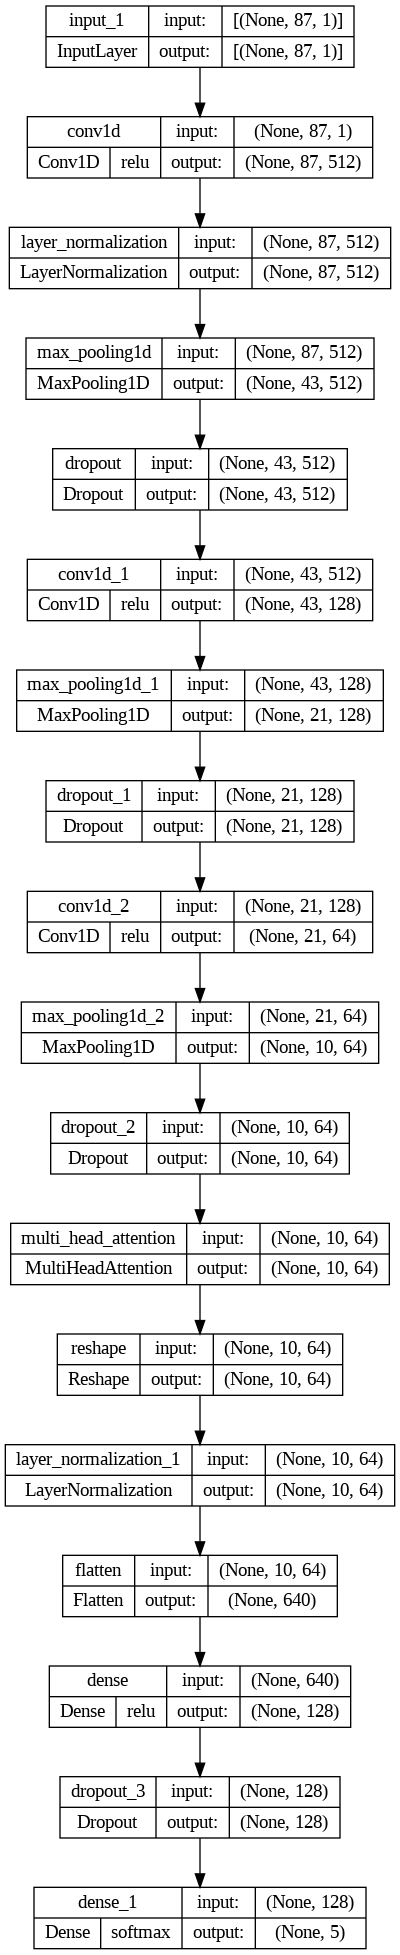

In [20]:
keras.utils.vis_utils.plot_model(model,to_file='multiclass_model.png',show_shapes=True, show_layer_names=True, show_layer_activations = True)

In [21]:
optimizer = tf.keras.optimizers.experimental.RMSprop(
    learning_rate=0.001,
    rho=0.9,
    momentum=0.0,
    epsilon=1e-08,
    centered=False,
    weight_decay=None,
    clipnorm=None,
    clipvalue=None,
    global_clipnorm=None,
    use_ema=False,
    ema_momentum=0.99,
    ema_overwrite_frequency=100,
    jit_compile=True
)
# train_op = tf.keras.optimizers.adam(amsgrad=True)
model.compile(optimizer = optimizer ,loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [22]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import CSVLogger

filepath = '/content/drive/My Drive/Datasets/NSL-KDD/multi_small_model_with_att_one_hot_rms_min_lr_0.001.hdf5'
checkpoint = ModelCheckpoint(filepath, 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True,
                             mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', mode='max',factor=0.2, patience=5, min_lr=0.001, cooldown = 1, focus='val_accuracy')
# reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', mode='max',factor=0.2, patience=5, min_lr=0.001)

csv_logger = CSVLogger('training.log')

callbacks_list = [checkpoint, reduce_lr, csv_logger]

In [23]:
history = model.fit(x_train, Y_train, epochs = 150, validation_data=(x_test, Y_test),batch_size = 512, callbacks= callbacks_list)

Epoch 1/150
247/247 [==============================] - ETA: 0s - loss: 0.3549 - accuracy: 0.8740
Epoch 1: val_accuracy improved from -inf to 0.73385, saving model to /content/drive/My Drive/Datasets/NSL-KDD/multi_small_model_with_att_one_hot_rms_min_lr_0.001.hdf5
247/247 [==============================] - 35s 80ms/step - loss: 0.3549 - accuracy: 0.8740 - val_loss: 1.7578 - val_accuracy: 0.7339 - lr: 0.0010
Epoch 2/150
246/247 [============================>.] - ETA: 0s - loss: 0.0254 - accuracy: 0.9929
Epoch 2: val_accuracy improved from 0.73385 to 0.85047, saving model to /content/drive/My Drive/Datasets/NSL-KDD/multi_small_model_with_att_one_hot_rms_min_lr_0.001.hdf5
247/247 [==============================] - 18s 74ms/step - loss: 0.0254 - accuracy: 0.9930 - val_loss: 2.0874 - val_accuracy: 0.8505 - lr: 0.0010
Epoch 3/150
246/247 [============================>.] - ETA: 0s - loss: 0.0132 - accuracy: 0.9968
Epoch 3: val_accuracy improved from 0.85047 to 0.85380, saving model to /content

In [24]:
model = load_model('/content/drive/My Drive/Datasets/NSL-KDD/multi_small_model_with_att_one_hot_rms_min_lr_0.001.hdf5')

In [25]:
test_loss, test_acc = model.evaluate(x_21_test, y_21_test)

print(test_loss)
print(test_acc)

371/371 [==============================] - 2s 5ms/step - loss: 0.0130 - accuracy: 0.9952
0.012969860807061195
0.9951898455619812


In [26]:
accuracy = history.history['accuracy']
epochs = range(1, len(accuracy) + 1)

In [27]:
accuracy

[0.8740444183349609,
 0.9929508566856384,
 0.9968088269233704,
 0.9974676966667175,
 0.9979360699653625,
 0.9981980323791504,
 0.9985552430152893,
 0.9985473155975342,
 0.9987854361534119,
 0.9986822605133057,
 0.9990156888961792,
 0.9989362955093384,
 0.9990156888961792,
 0.9990236163139343,
 0.9991903305053711,
 0.9992141127586365,
 0.9991982579231262,
 0.9992935061454773,
 0.9993014335632324,
 0.999364972114563,
 0.9991188645362854,
 0.9993728995323181,
 0.9994125962257385,
 0.9992696642875671,
 0.9993569850921631,
 0.9994046092033386,
 0.999261736869812,
 0.9993728995323181,
 0.9994522929191589,
 0.9994760751724243,
 0.9994840025901794,
 0.9994681477546692,
 0.9994205236434937,
 0.9994681477546692,
 0.9994760751724243,
 0.9994919300079346,
 0.999444305896759,
 0.9995713233947754,
 0.9995792508125305,
 0.9995554685592651,
 0.9996904134750366,
 0.9995713233947754,
 0.9995951652526855,
 0.9995633959770203,
 0.9996507167816162,
 0.9995633959770203,
 0.9996110200881958,
 0.9995713233947

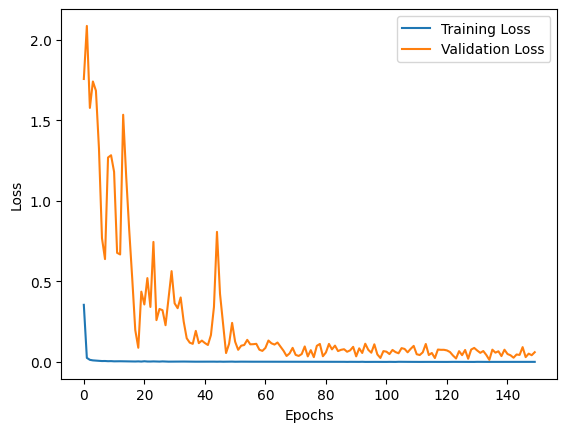

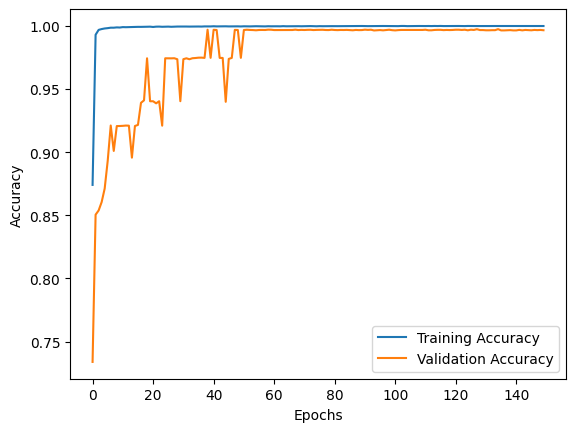

In [28]:
import matplotlib.pyplot as plt

# Load the log file and extract the data
log_data = pd.read_csv('training.log')
loss = log_data['loss']
val_loss = log_data['val_loss']
acc = log_data['accuracy']
val_acc = log_data['val_accuracy']

# Plot the loss curves
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the accuracy curves
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


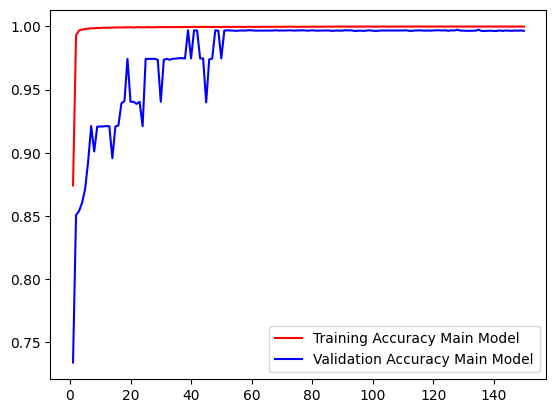

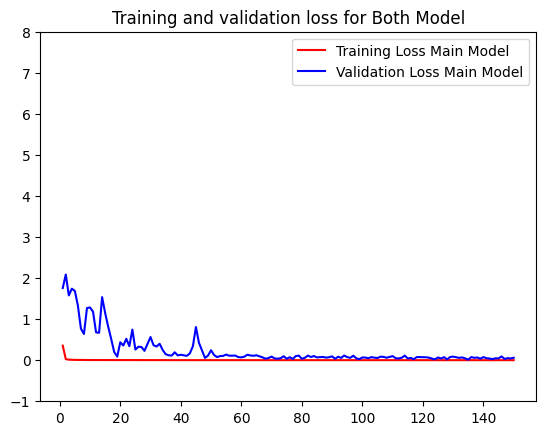

In [29]:
import matplotlib.pyplot as plt
main_acc = history.history['accuracy']

main_val_acc = history.history['val_accuracy']


main_loss = history.history['loss']

main_val_loss = history.history['val_loss']


epochs = range(1, len(main_acc) + 1)

plt.plot(epochs, main_acc, 'r', label='Training Accuracy Main Model')


plt.plot(epochs, main_val_acc, 'b', label='Validation Accuracy Main Model')
plt.legend()
plt.grid(False)
plt.savefig('Net_aaccuracy.png', bbox_inches='tight',dpi=600)

plt.figure()

plt.plot(epochs, main_loss, 'r', label='Training Loss Main Model')

plt.plot(epochs, main_val_loss, 'b', label='Validation Loss Main Model')

plt.ylim([-1, 8])
plt.title('Training and validation loss for Both Model')

plt.legend()
plt.grid(False)
plt.savefig('Net_loss.png', bbox_inches='tight',dpi=600)
plt.show()

# **Confusion Matrix**

371/371 [==============================] - 2s 4ms/step
[[2152    0    0    0    0]
 [   0 2402    0    0    0]
 [   0    0 4342    0    0]
 [   0    0   28   14   25]
 [   3    1    0    0 2883]]


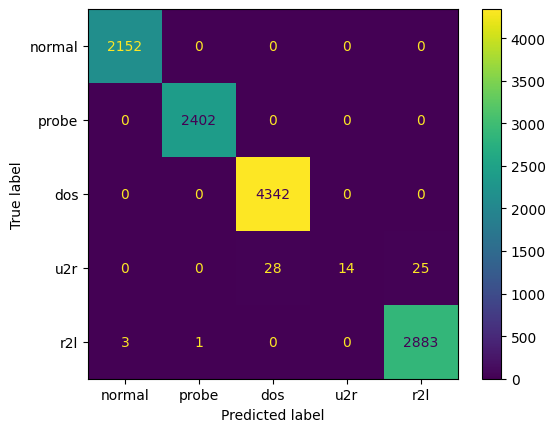

In [30]:
# Convert DataFrame to NumPy array
y_21_test_array = y_21_test.to_numpy()

# Reshape the one-hot encoded labels
Y_test_reshaped = y_21_test_array.reshape(-1, 5)

# Obtain the predicted values
Y_pred = model.predict(x_21_test)

# Convert the one-hot encoded labels to scalar values
Y_test_scalar = np.argmax(Y_test_reshaped, axis=1)
Y_pred_scalar = np.argmax(Y_pred, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(Y_test_scalar, Y_pred_scalar)

# Print the confusion matrix
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["normal","probe","dos","u2r","r2l"])
disp.plot()
plt.savefig('confusion_Net_multiclass.png', bbox_inches='tight',dpi=600)
plt.grid(False)
plt.show()

In [31]:
CM = ConfusionMatrix(actual_vector=Y_test_scalar, predict_vector=Y_pred_scalar)
CM.relabel(mapping={0:"normal",1:"probe",2:"dos",3:"u2r",4:"r2l"})

In [32]:
print(CM)

Predict      normal       probe        dos          u2r          r2l          
Actual
normal       2152         0            0            0            0            

probe        0            2402         0            0            0            

dos          0            0            4342         0            0            

u2r          0            0            28           14           25           

r2l          3            1            0            0            2883         





Overall Statistics : 

95% CI                                                            (0.99394,0.99644)
ACC Macro                                                         0.99808
ARI                                                               0.9922
AUNP                                                              0.99653
AUNU                                                              0.92006
Bangdiwala B                                                      0.99431
Bennett S                         

In [33]:
from sklearn.metrics import classification_report
target_names = ['normal','probe','dos','u2r','r2l']
print(classification_report(Y_test_scalar, Y_pred_scalar, target_names=target_names))

              precision    recall  f1-score   support

      normal       1.00      1.00      1.00      2152
       probe       1.00      1.00      1.00      2402
         dos       0.99      1.00      1.00      4342
         u2r       1.00      0.21      0.35        67
         r2l       0.99      1.00      0.99      2887

    accuracy                           1.00     11850
   macro avg       1.00      0.84      0.87     11850
weighted avg       1.00      1.00      0.99     11850



In [34]:
acc_21 = accuracy_score(Y_test_scalar, Y_pred_scalar)* 100
recall = recall_score(Y_test_scalar, Y_pred_scalar , average="weighted")
precision = precision_score(Y_test_scalar, Y_pred_scalar , average="weighted")
f1 = f1_score(Y_test_scalar, Y_pred_scalar, average="weighted")

In [35]:
print("accuracy")
print("%.3f" %acc_21)
print("racall")
print("%.3f" %recall)
print("precision")
print("%.3f" %precision)
print("f1score")
print(f1)

accuracy
99.519
racall
0.995
precision
0.995
f1score
0.9937349521858656


In [36]:
# data = pd.read_csv('/content/training.log', sep=',', header=None)
# data.to_csv('training.csv', index=False)

In [37]:
# from google.colab import files
# files.download('training.csv')